In [1]:
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
import fiona
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from fiona.crs import from_epsg
from itertools import chain
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection


shapefile="map/LA-ZIPCodes/geo_export_1cf2ba2c-a35e-47e7-a586-b3ff394055e9.shp"
shp = fiona.open(shapefile)
bds = shp.bounds
print (bds)

shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

(-118.94469074608364, 32.7952008298079, -117.64637387599755, 34.82329918842445)


(311,
 5,
 [-118.94469074608364, 32.7952008298079, 0.0, 0.0],
 [-117.64637387599755, 34.82329918842445, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x109f90b10>)

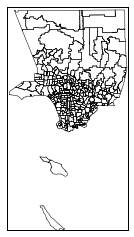

In [2]:
m = Basemap(
    projection='tmerc',
    lon_0= -118.2437,
    lat_0= 34.0522,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
#     llcrnrlat=33.5 - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'map/LA-ZIPCodes/geo_export_1cf2ba2c-a35e-47e7-a586-b3ff394055e9',
    'LA',
    color='black',
    zorder=2)

In [3]:
# m.SF_info

In [4]:

# Set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.LA],
    'zipcode': [ward['zipcode'] for ward in m.LA_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(dat['longitude'],dat['latitude'])])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

In [5]:
df_map.head()

,poly,zipcode,area_m,area_km
0,"POLYGON ((66900.54807502548 131065.7662983568,...",90001,8.877927e+06,88.779270
1,"POLYGON ((67739.2150122337 127934.9022620241, ...",90002,7.687667e+06,76.876669
2,"POLYGON ((64077.32727732149 131078.2332564845,...",90003,9.537168e+06,95.371681
3,"POLYGON ((63141.96727358244 141521.1837158776,...",90004,7.800037e+06,78.000371
4,"POLYGON ((58302.39284225237 139129.3791716908,...",90005,2.641861e+06,26.418609


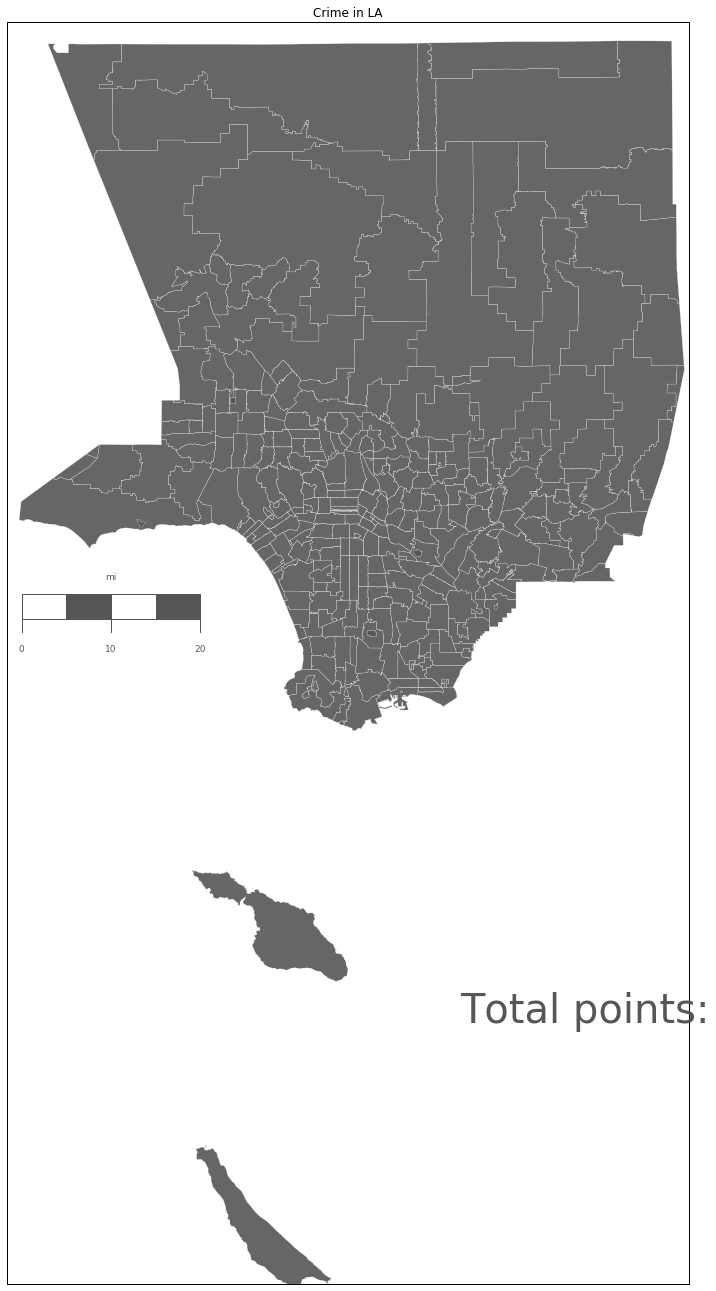

In [6]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='w', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=True)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
# dev = m.scatter(
#     [geom.x for geom in ldn_points],
#     [geom.y for geom in ldn_points],
#     5, marker='o', lw=.25,
#     facecolor='#33ccff', edgecolor='w',
#     alpha=0.9, antialiased=True,
#     label='Blue Plaque Locations', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# copyright and source data info
smallprint = ax.text(
    1.03, 0.2,
    'Total points:',
    ha='right', va='bottom',
    size=40,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.18, coords[1] + 1.11,
    coords[0], coords[1],
    20.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555', units='mi',
    zorder=5)
plt.title("Crime in LA")
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(15, 20)
# plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()

In [7]:
from pysal.esda.mapclassify import Natural_Breaks
import numpy as np

In [8]:
df_map['count'] = np.random.randint(1000, 10000, df_map.shape[0])


In [9]:
# Calculate Jenks natural breaks for density
breaks = Natural_Breaks(df_map['count'].values, k=5)
df_map['jenks_bins'] = breaks.yb

In [10]:
len(breaks.yb)

344

In [11]:
df_map.head()

,poly,zipcode,area_m,area_km,patches,count,jenks_bins
0,"POLYGON ((66900.54807502548 131065.7662983568,...",90001,8.877927e+06,88.779270,"Poly((66900.5, 131066) ...)",6575,3
1,"POLYGON ((67739.2150122337 127934.9022620241, ...",90002,7.687667e+06,76.876669,"Poly((67739.2, 127935) ...)",5529,2
2,"POLYGON ((64077.32727732149 131078.2332564845,...",90003,9.537168e+06,95.371681,"Poly((64077.3, 131078) ...)",5141,2
3,"POLYGON ((63141.96727358244 141521.1837158776,...",90004,7.800037e+06,78.000371,"Poly((63142, 141521) ...)",7070,3
4,"POLYGON ((58302.39284225237 139129.3791716908,...",90005,2.641861e+06,26.418609,"Poly((58302.4, 139129) ...)",3370,1


In [12]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

NameError: name 'jenks_labels' is not defined

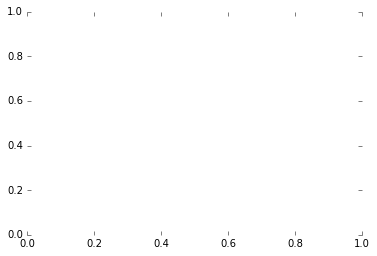

In [13]:
from matplotlib.colors import Normalize
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=None)
cb.ax.tick_params(labelsize=30)

# # Show highest densities, in descending order
# highest = '\n'.join(
#     value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
# highest = 'Most Dense Wards:\n\n' + highest
# # Subtraction is necessary for precise y coordinate alignment
# details = cb.ax.text(
#     -1., 0 - 0.007,
#     highest,
#     ha='right', va='bottom',
#     size=5,
#     color='#555555')

# Bin method, copyright and source data info
# smallprint = ax.text(
#     1.03, 0,
#     'Classification method: natural breaks\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org',
#     ha='right', va='bottom',
#     size=4,
#     color='#555555',
#     transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.2, coords[1] + 1.015,
    coords[0], coords[1],
    20.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555', units='mi',
    zorder=5)
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(15, 20)
# plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()